# Testing possible atom mappings in perses
### Module to test how a hybrid system will be generated for a system

    * This does _not_ check if hydrogens are mapped or not. That is handled by class SmallMoleculeSetProposalEngine as a system needs to be generated and the hydrogens restraints need to be checked
    * AtomMapper also does not check that the minimal number of core atoms are retained by a map. If

In [1]:
# from perses.utils.openeye import createOEMolFromSDF
from perses.utils.smallmolecules import render_atom_mapping
from perses.utils.openeye import smiles_to_oemol
from perses.rjmc.topology_proposal import AtomMapper
from openeye import oechem
import itertools
from IPython.display import display, Image

In [2]:
##### molecules to play with

smiles = {'benzene':'c1ccccc1','toluene':'c1ccccc1C','nitrobenzene':'C1=CC=C(C=C1)[N+](=O)[O-]','cyclohexane':'C1CCCCC1'}
list_of_mols = []
for name,smi in smiles.items():
    mol = smiles_to_oemol(smi, title=name)
    list_of_mols.append(mol)
    
print(f'{len(list_of_mols)} oemols have been generated')

4 oemols have been generated


#### Starting by just using the three default options in perses

INFO:proposal_generator:Cannot generate atom map without breaking rings, trying again with weaker mapping.
INFO:proposal_generator:Cannot generate atom map without breaking rings, trying again with weaker mapping.


Doing strong mapping
Cannot map benzene to toluene effectively with strong map strength
Cannot map benzene to nitrobenzene effectively with strong map strength
Cannot map benzene to cyclohexane effectively with strong map strength
toluene ---> nitrobenzene ✓


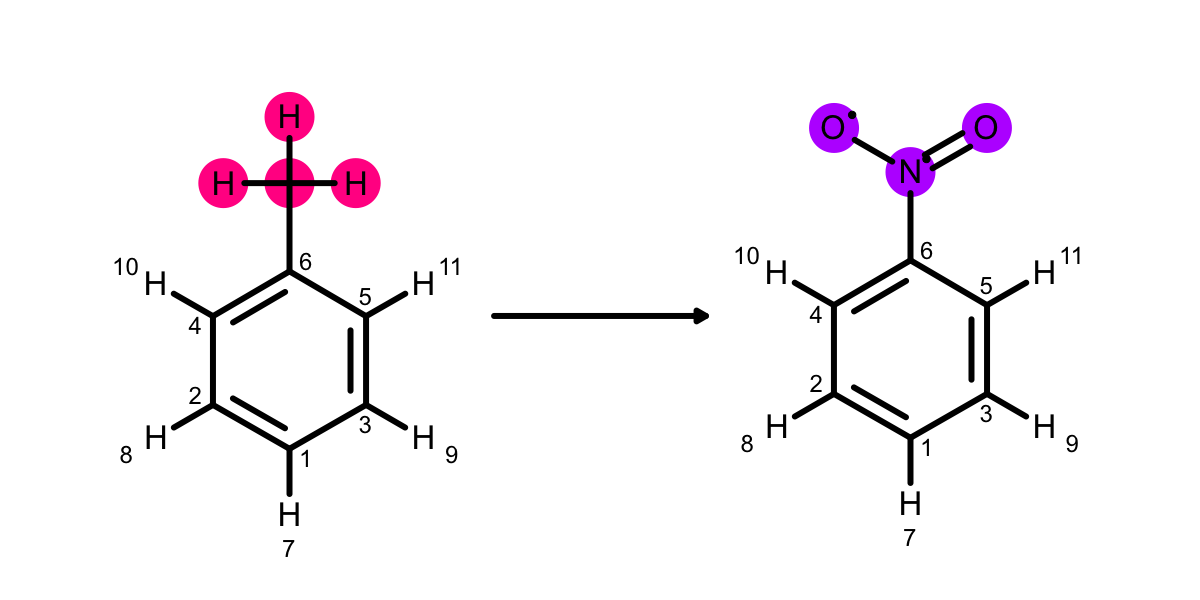

Cannot map toluene to cyclohexane effectively with strong map strength
Cannot map nitrobenzene to cyclohexane effectively with strong map strength



In [3]:
# looping over default mapping strengths
names_and_oemols = dict(zip(smiles.keys(),list_of_mols))

# print(names_and_oemols.keys())

for map_strength in ['strong']:
    print(f'Doing {map_strength} mapping')
    for nameA,nameB in itertools.combinations(names_and_oemols,2):
        molA = names_and_oemols[nameA]
        molB = names_and_oemols[nameB]
        Mapper = AtomMapper([molA,molB],map_strength=map_strength)

        if Mapper.atom_map is None or len(Mapper.atom_map) < 3:
            # too many unique atoms
            print(f'Cannot map {nameA} to {nameB} effectively with {map_strength} map strength')
        else:
            print(f'{nameA} ---> {nameB} '+u'\u2713')
            render_atom_mapping(f'{nameA}to{nameB}_{map_strength}.png', Mapper.current_molecule, Mapper.proposed_molecule, Mapper.atom_map)
            i = Image(filename=f'{nameA}to{nameB}_{map_strength}.png')
            display(i)
    print()

#### Now lets try a few different mapping schemes using openeye's `OEExprOpts`

https://docs.eyesopen.com/toolkits/python/oechemtk/OEChemConstants/OEExprOpts.html

cyclohexane ---> benzene ✓


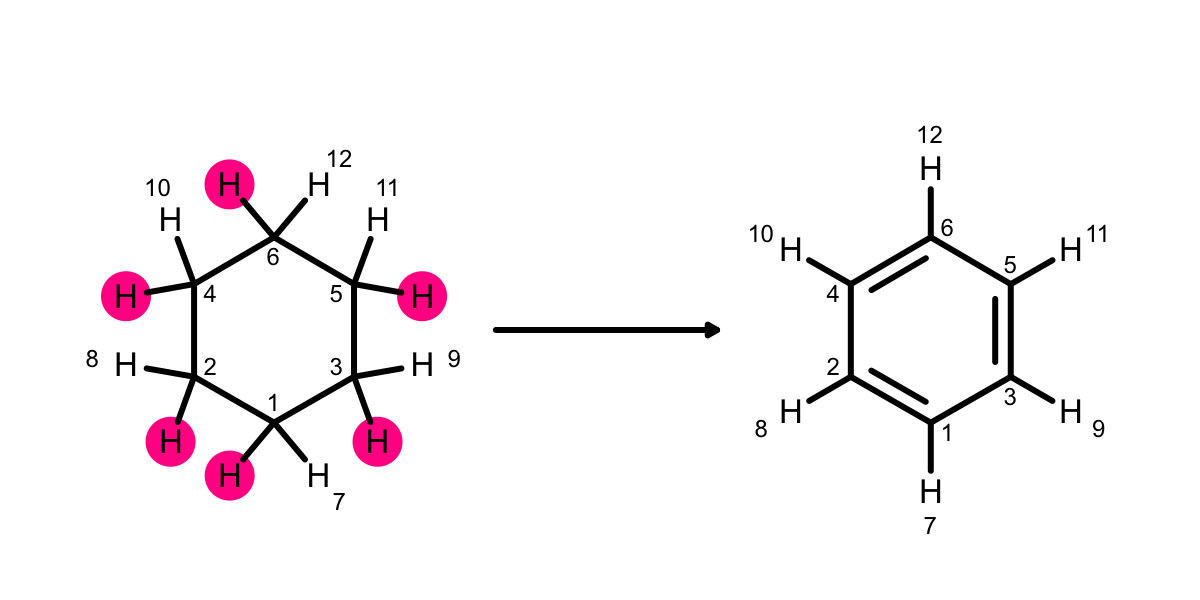


cyclohexane ---> toluene ✓


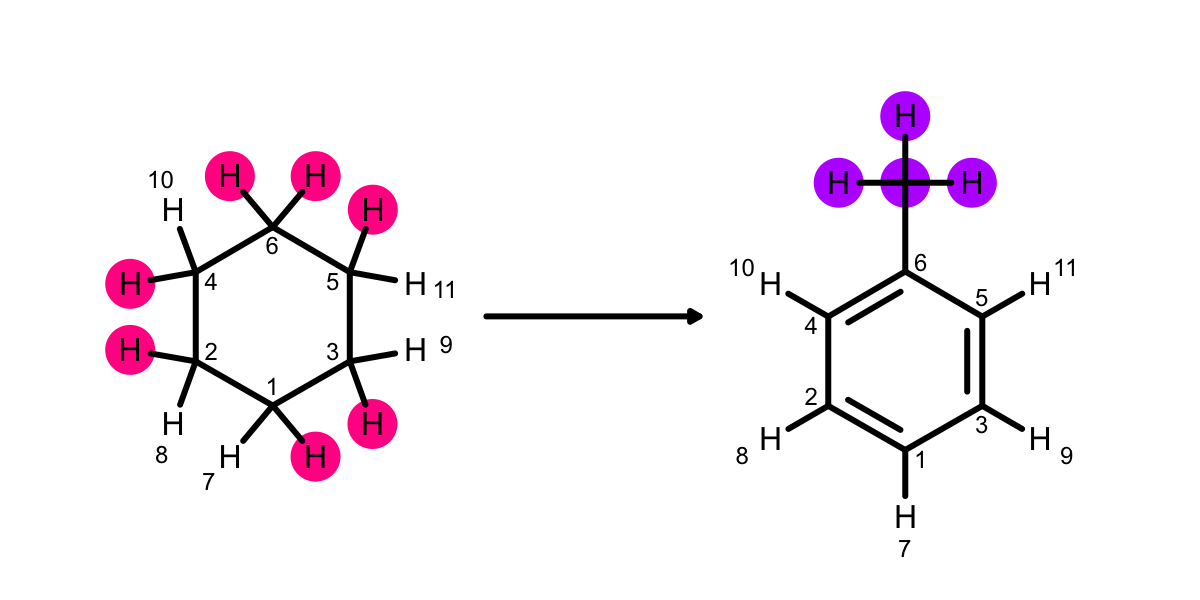


cyclohexane ---> nitrobenzene ✓


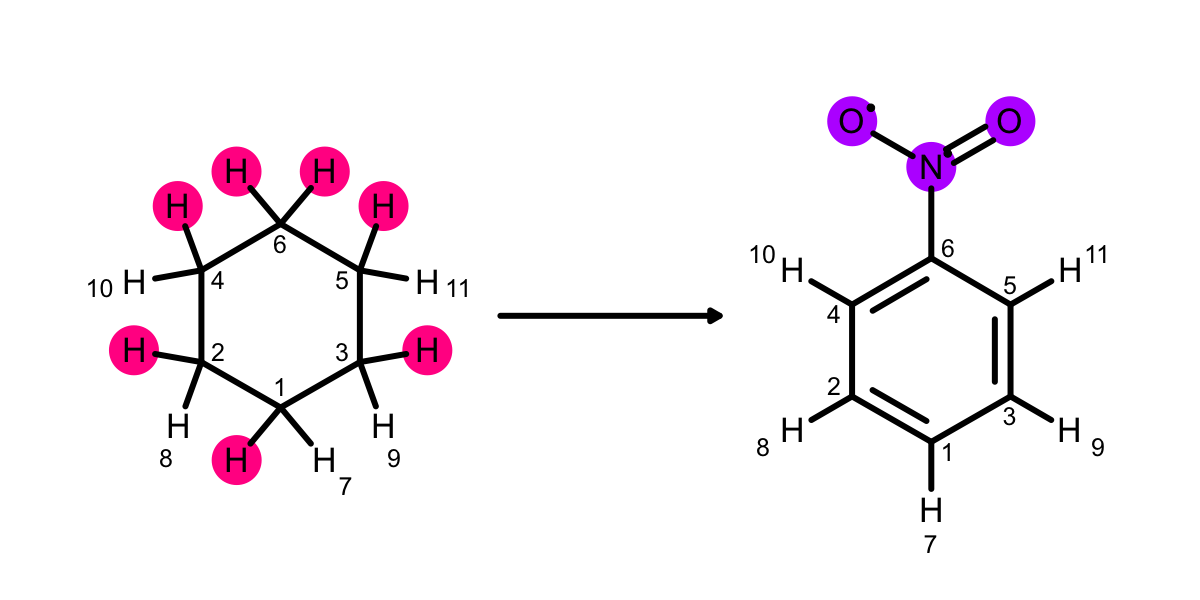

In [6]:
# this just checks atoms are in rings of the same size, with no check for aromaticity
atom_expr = oechem.OEExprOpts_IntType
bond_expr = oechem.OEExprOpts_RingMember 


nameA = 'cyclohexane'

for nameB in names_and_oemols.keys():
    if nameB == nameA:
        continue
    molA = names_and_oemols[nameA]
    molB = names_and_oemols[nameB]    
    Mapper = AtomMapper([molA,molB],atom_expr=atom_expr,bond_expr=bond_expr)
    if len(Mapper.atom_map) < 3:
        # too many unique atoms
        print(f'Cannot map {nameA} to {nameB} effectively with {map_strength} map strength')
    else:
        print(f'{nameA} ---> {nameB} '+u'\u2713')
        render_atom_mapping(f'{nameA}to{nameB}.png', Mapper.current_molecule, Mapper.proposed_molecule, Mapper.atom_map)
        i = Image(filename=f'{nameA}to{nameB}.png')
        display(i)
        print()
    